In [1]:
## ---- Global Cell Set Characterization Notebook ----
## This is a modified version of the 0300.00.00 Notebook
## for Some Reformatted Plots Needed for the Paper
## Load Analysis Parameters (Parm1)
## Read R Data Object from Prior Notebook (CDS1)
## Characterize Partition - Statatics (Monocle3)
## Compute Top Genes By Partition an Save Result (added all 10/29/2019)
## Create Global Cell Plots as Needed and Save Results
## Create Global Partition DOT Plots as Needed and Save Results
## Perform Eigencell Analysis and Plot Results as Needed and Save Results
## Perform Cross Partition Network Analysis
## Save CDS Result As An R Data Object (CDS2)
## Compute the mean of the maximum pseudo_R2rds for Tom's genes in the dot plot

In [2]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [3]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)

In [6]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
                        'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [7]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [8]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [9]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [10]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [11]:
## Declare Tom's best genes for definiting cell types
toms_markers5 <- c('NRXN1', 'CLU', 'ICAM2',
                 'CD14', 'CD68', 'AIF1',
                 'VWF', 'EDN1', 'ECSCR',
                 'MKI67', 'UBE2C', 'TOP2A',
                 'ACTA2', 'TAGLN', 'MYL9',
                 'ACKR1', 'SPARCL1', 'PECAM1',
                 'CALD1', 'MGP', 'DCN',
                 'NKG7', 'XCL1', 'CTSW',
                 'CD8A', 'TRAC', 'CD2',
                 'MS4A1', 'CD79A', 'BANK1',
                 'CD69', 'CXCR4', 'IL7R',
                 'LILRA4', 'IRF7', 'CLEC4C',
                 'MZB1', 'JCHAIN', 'TNFRSF17',
                 'LST1', 'FCGR3B', 'S100A8',
                 'TPSAB1', 'CPA3', 'MS4A2')
toms_gene_ids5 <- short2geneid[toms_markers5]

toms_markers6 <- c('AIF1', 'CD14', 'CD68',
                'VWF', 'PECAM1', 'ECSCR',
                'CALD1', 'MYL9', 'TAGLN',
                'NKG7', 'XCL1', 'CTSW',
                'CD2', 'TRAC', 'CD69',
                'CD79A', 'MS4A1', 'IGKC')
toms_gene_ids6 <- short2geneid[toms_markers6]

doug_markers1 <- c('AIF1', 'LYZ', 'FCER1G',  'CD68',
                'RNASE1', 'PECAM1', 'IGFBP4', 'ADIRF', 
                'SOD3', 'MYL9', 'CALD1', 'GSN',
                'TYROBP', 'NKG7', 'CTSW', 'CD69',
                'CD3D', 'CD2', 'TRBC2', 'TRAC',
                'MS4A1', 'CD79A', 'HLA-DQA1', 'CD37')
dougs_gene_ids1 <- short2geneid[doug_markers1]

In [12]:
## The stats data was output in the last notebook
# ## Force the partition breakdown (cell counts by partition across patients, disease and healthy)
# no.parts <- 6
# part_stats <- as.data.frame(matrix('', nrow = no.parts,
#                                    ncol = length(cellgrps)), stringsAsFactors = FALSE)

In [13]:
## The stats data was output in the last notebook
# ## Add the cell groups and patient IDs to the first two rows
# part_stats <- rbind(cellpats, cellgrps, part_stats)
# ## Add the partition names (cell types), and first two column row names as well
# row.names(part_stats) <- c('Patient ID', 'Condition', celltypes6)

In [14]:
# parts <- partitions(down_stdycds)
# for (c in 1:dim(part_stats)[2]) {
#     for (r in 3:dim(part_stats)[1]) {
#         cells <- sum((parts == (r - 2)) &
#                      (colData(down_stdycds)$patient ==  cellpats[c])  &
#                      (colData(down_stdycds)$condition ==  cellgrps[c]))
#         part_stats[r, c] <- cells
#     }
# }

In [15]:
# ## Save the partition statistics
# write.table(part_stats,
#             file = paste(ps$outdir, 'Aggregated.downsampled.QC.Partition.CellCount.Stats.txt', sep = ''),
#             col.names = FALSE)

In [20]:
## Compute top 500 marker files
# topmarkerfile <- paste(ps$outdir, 'Aggregated.downsampled.QC.Top500MarkersPer.Rev2.tsv', sep = '')
marker_test_res_top500 <- top_markers(down_stdycds, group_cells_by = "assigned_cell_type",
                                       genes_to_test_per_group = 500, # dim(down_stdycds)[1], 
                                       reference_cells = dim(down_stdycds)[2], cores = 4)

  |=======================================================| 100%, Elapsed 00:04
  |=======================================================| 100%, Elapsed 05:09


In [27]:
## Save top 500 markers to a file
    marker_test_res_top500_with_GC <- marker_test_res_top500[,c(1,2,2,3:10)]
    colnames(marker_test_res_top500_with_GC)[2] <- 'gene_cards'
    nmarkers1 <- dim(marker_test_res_top500_with_GC)[1]
    gc_hyper1 <- '=HYPERLINK(CONCAT("https://www.genecards.org/Search/Keyword?queryString=", '
    gc_hyper1 <- paste(gc_hyper1, 'A', 2:(nmarkers1 + 1), '), C', 2:(nmarkers1 + 1), ')', sep ='')
    marker_test_res_top500_with_GC$gene_cards = gc_hyper1

In [28]:
## Actually write the file
top500markerfile <- paste(ps$outdir, 'Aggregated.downsampled.QC.Top500MarkersPer.Rev2.tsv', sep = '')
write.table(marker_test_res_top500_with_GC, file = top500markerfile,
            row.names = FALSE, col.names = TRUE,
            sep = '\t', quote = FALSE)

In [24]:
## Compute all top marker files
# topmarkerfile <- paste(ps$outdir, 'Aggregated.downsampled.QC.TopAllMarkersPer.Rev2.tsv', sep = '')
marker_test_res_topall <- top_markers(down_stdycds, group_cells_by = "assigned_cell_type",
                                       genes_to_test_per_group = dim(down_stdycds)[1], 
                                       reference_cells = dim(down_stdycds)[2], cores = 4)

  |=======================================================| 100%, Elapsed 00:04
  |====================================================| 100%, Elapsed 04:13:12


In [25]:
## Save all top markers to a file
    marker_test_res_topall_with_GC <- marker_test_res_topall[,c(1,2,2,3:10)]
    colnames(marker_test_res_topall_with_GC)[2] <- 'gene_cards'
    nmarkers1 <- dim(marker_test_res_topall_with_GC)[1]
    gc_hyper1 <- '=HYPERLINK(CONCAT("https://www.genecards.org/Search/Keyword?queryString=", '
    gc_hyper1 <- paste(gc_hyper1, 'A', 2:(nmarkers1 + 1), '), C', 2:(nmarkers1 + 1), ')', sep ='')
    marker_test_res_topall_with_GC$gene_cards <- gc_hyper1

    

ERROR: Error in eval(expr, envir, enclos): object 'marker_test_res_topall' not found


In [26]:
## Actually write the file
topmarkerfile <- paste(ps$outdir, 'Aggregated.downsampled.QC.TopAllMarkersPer.Rev2.tsv', sep = '')
write.table(marker_test_res_topall_with_GC, file = topmarkerfile,
            row.names = FALSE, col.names = TRUE,
            sep = '\t', quote = FALSE)

In [12]:
topmarkerfile <- paste(ps$outdir, 'Aggregated.downsampled.QC.TopAllMarkersPer.Rev2.tsv', sep = '')
marker_test_res_topall_with_GC <- read.table(topmarkerfile, header = TRUE, sep = '\t')

In [34]:
## Prepare to create a dot plot (modified version of Monocle 3)
top_specific_markers3 <- marker_test_res_top500_with_GC %>%
                            filter(fraction_expressing >= 0.10) %>%
                            group_by(cell_group) %>%
                            top_n(3, pseudo_R2)
top_specific_marker_ids <- unique(top_specific_markers3 %>% pull(gene_id))
top_specific_genes <- as.character(geneid2short[top_specific_marker_ids])
top_specific_marker_ids <- short2geneid[top_specific_genes]

In [35]:
source('~/code/CSC.Run2/0700.00.00.Carotid.SC.Utilities.01.r')

In [42]:
## This is a dot plot of the toms list of marker genes (5th iteration)
g5 <- plot_genes_by_group2(down_stdycds,
                    axis_order = "group_marker",
                    toms_gene_ids6,
                    group_cells_by = "assigned_cell_type",
                    ordering_type = "as_ordered", # "cluster_row_col" "as_ordered"
                    max.size = 8,
                    norm_method = 'size_only',
                    scale_max = 3, scale_min = -3)

In [30]:
## Write the updated dot plot to a file
plotfile <- 'Aggregated.downsampled.QC.DougsGenes.DOTPlot.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [31]:
pdf(plotfp, width = 10, height = 12)
g5
dev.off()

png 
  2

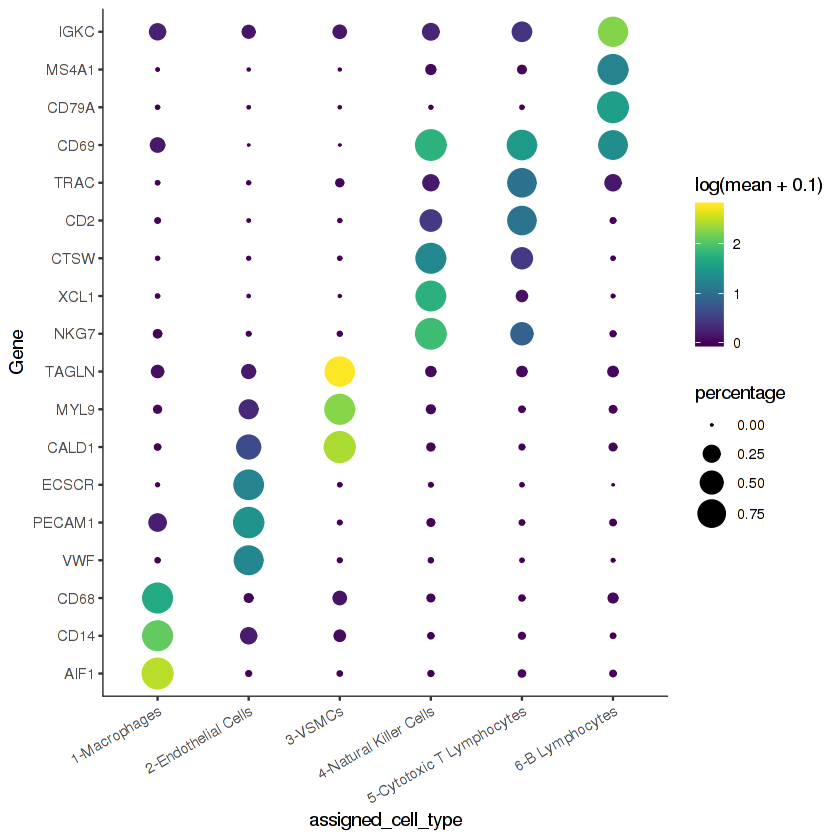

In [43]:
g5

In [76]:
doug_markers1 <- toms_markers6
dougs_gene_ids1 <- toms_gene_ids6

In [77]:
## Get the gene data for dougs_markers1
GlobExpVal <- marker_test_res_topall_with_GC[marker_test_res_topall_with_GC$gene_short_name.1 %in%
                                             doug_markers1,]
GlobExpVal$gene_short_name.1 <- as.character(GlobExpVal$gene_short_name.1)

In [78]:
## Temporarily regroup the GlobExpVal object, and then replace it
tempGEV <- GlobExpVal[,c(3, 4, 6, 7)]
colnames(tempGEV) <- c('Gene', 'Group', 'mean', 'percentage')
tempGEV$Group <- as.integer(substr(tempGEV$Group, 1, 1))
GlobExpVal <- tempGEV

In [79]:
## This is a special dot plot created for Tom's poster
## This is all setup in this cell
##-----------------
## Intialize data frame for dot plot
dotmat <- as.data.frame(matrix(as.integer(0), nrow = dim(GlobExpVal)[1] , ncol = 6), stringsAsFactors = FALSE)
colnames(dotmat) <- c('xname', 'yname', 'x', 'y', 'size', 'color') 
## Load the data frame
dotmat$y <- as.integer(GlobExpVal$Group)
for (i in 1:dim(GlobExpVal)[1]) {
    dotmat$x[i] <- as.integer(which(doug_markers1 %in%  as.character(GlobExpVal$Gene[i]))[1])
    }
dotmat$xname <- doug_markers1[dotmat$x]
dotmat$yname <- as.character(celltypes6[dotmat$y])
dotmat$size <- GlobExpVal$percentage * 100
dotmat$color <- GlobExpVal$mean
dotmat$stroke <- as.integer(0)
dotmat$fill <- 'white'
## Some settings and precomputed values
xmargin <- .5
ymargin <- .5
dotscale <- 1.5
dotmat$scsize <- dotscale * dotmat$size
xlimlow <- min(dotmat$x) - xmargin
xlimhi <- max(dotmat$x) + xmargin
ylimlow <- min(dotmat$y) - ymargin
ylimhi <- max(dotmat$y) + ymargin
## Get the axis tick labels
xnames <- doug_markers1 # unique(dotmat$xname)
ynames <- celltypes6 # unique(dotmat$yname)
## Change the order of y axis
dotmat$y <- 7 - dotmat$y
ynames <- ynames[6:1]
## Some ggplot text formatting
red.bold.italic.text <- element_text(face = "bold.italic", color = "black")
black.90italic.text <- element_text(face = "bold.italic", hjust = 1,
                                    color = "black", angle = 90, vjust = .5, size = 8)

In [80]:
## Create the actual dot plot object
g6 <- ggplot(dotmat, aes(x = x, y = y)) + 
    geom_point(aes(col = color, size = size, stroke = size/2), stroke = 0) +
    scale_radius(range = c(1, 5)) +
    coord_cartesian(xlim = c(xlimlow, xlimhi), ylim = c(ylimlow, ylimhi)) +
    xlab("") + ylab("")  +                  
    scale_x_continuous(breaks = seq(min(dotmat$x),  max(dotmat$x), 1), labels = xnames) + 
    scale_y_continuous(breaks = seq(min(dotmat$y), max(dotmat$y), 1), labels = ynames) +
    scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
    theme_bw() + # labs(subtitle="BW Theme") +
    theme_classic() + # labs(subtitle="Classic Theme") + 
    theme(axis.text.x = black.90italic.text) + 
    theme(legend.position = 'bottom', legend.direction = 'vertical') +
    theme(plot.margin = margin(.5, .5, .5, .5, "in")) + # , plot.background = element_rect(fill = "white"))
    theme(panel.border = element_rect(colour = "black", fill = NA)) + 
    labs(color = "", size = "") 

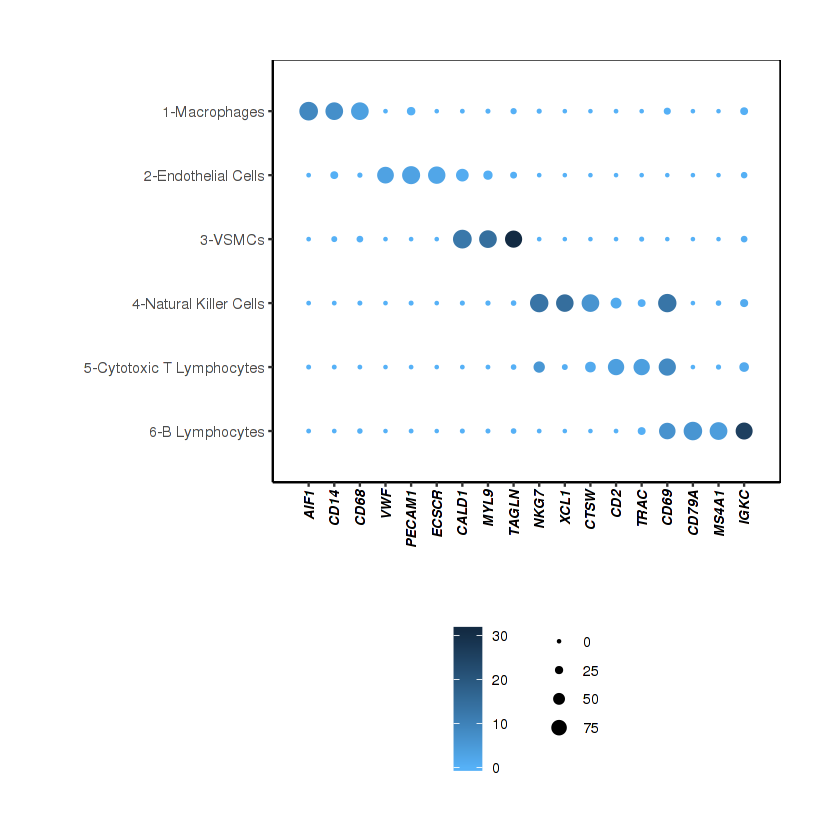

In [81]:
g6

In [82]:
## set up the dot plot file
plotfile <- 'Aggregated.downsampled.QC.TomsGenes.PosterDOTPlot.Rev2.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [91]:
## Actually create the file, adding annotations
pdf(plotfp, width = 6, height = 5)
    g6
    my_text1 <- ''# 'Percent of cells in\npartition with 1+ reads\ncorresponding to\ngene marker'
    my_grob1 <- grid.text(my_text1, x = .9 - .025,  y =.09 + 0.07 + .08, hjust = 1,
                        gp = gpar(col = "black", fontsize = 10, fontface = "bold"))
    my_text2 <- '' # 'Scaled Expression'
    my_grob2 <- grid.text(my_text2, x = .5 - .06,  y =.21 + 0.035 + .14, 
                        gp = gpar(col = "black", fontsize = 10, fontface = "bold"))
dev.off()

png 
  2

In [143]:
## Create a 3 panel plot, one per patient with partitions colored healthy/diseased, 
pat1 <- down_stdycds[, down_stdycds@colData@listData$patient == "ID Number 1"]
pat2 <- down_stdycds[, down_stdycds@colData@listData$patient == "ID Number 2"]
pat3 <- down_stdycds[, down_stdycds@colData@listData$patient == "ID Number 3"]

In [144]:
## Create the graph objects of the three panels
gp1 <- plot_cells(pat1, color_cells_by="condition", group_cells_by="partition",
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp1 <- gp1 + ylab('') + xlab('Patient 1')

gp2 <- plot_cells(pat2, color_cells_by="condition", group_cells_by="partition",
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp2 <- gp2 + ylab('') + xlab('Patient 2')

gp3 <- plot_cells(pat3, color_cells_by="condition", group_cells_by="partition",
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp3 <- gp3 + ylab('') + xlab('Patient 3')

In [145]:
## 3 Panel parition plot, patient 1, 2 and 3, colorzed by health/disease, no legend
plotfile <- 'Aggregated.downsampled.QC.3Panel.Patient.NoLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [146]:
## Write out the plot file
pdf(plotfp, width = 9, height = 2.5)
   grid.arrange(gp1, gp2, gp3, nrow = 1, respect = TRUE)
dev.off()

png 
  2

In [147]:
## Similar 3 Panel Plot, but with Legends
gp1b <- plot_cells(pat1, color_cells_by="condition", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp1b <- gp1b + ylab('') + xlab('Patient 1')

gp2b <- plot_cells(pat2, color_cells_by="condition", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp2b <- gp2b + ylab('') + xlab('Patient 2')

gp3b <- plot_cells(pat3, color_cells_by="condition", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp3b <- gp3b + ylab('') + xlab('Patient 3')

In [148]:
## 3 Panel parition plot, patient 1, 2 and 3, colorzed by health/disease, no legend
plotfile <- 'Aggregated.downsampled.QC.3Panel.Patient.WithLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [149]:
## Write out the plot file
pdf(plotfp, width = 11.3, height = 2.5)
   grid.arrange(gp1b, gp2b, gp3b, nrow = 1, respect = FALSE)
dev.off()

png 
  2

In [150]:
## Set up file for partition plot with legend showing assigned cell types
plotfile <- 'Aggregated.downsampled.QC.Cells.Partitions.WithLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [151]:
## Plot partitions with legend showing cell types
pdf(plotfp, width = 8, height = 6)
gtop1 <- plot_cells(down_stdycds, color_cells_by="assigned_cell_type", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gtop1
dev.off()


png 
  2

In [152]:
## Set up file for partition plot with legend showing assigned cell types
plotfile <- 'Aggregated.downsampled.QC.Cells.Partitions.WithLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')




In [153]:
pdf(plotfp, width = 4, height = 3)
gtop2 <- plot_cells(down_stdycds, color_cells_by="partition", group_cells_by="partition",
                   label_cell_groups = TRUE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gtop2 + xlab('') + ylab('') + theme(
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.ticks = element_blank())

dev.off()

png 
  2

In [154]:
## 2 Panel cell plots colored by patient and condition using legends
plotfile <- 'Aggregated.downsampled.QC.2Panes.ByPatient.ByCondition.WithLegendRev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [155]:
gp1 <- plot_cells(down_stdycds, color_cells_by = "patient", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp1 <- gp1 + ylab('') + xlab('by Patient')

gp2 <- plot_cells(down_stdycds, color_cells_by = "condition", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp2 <- gp2 + ylab('') + xlab('by Condition')


In [156]:
## Write the 2 panel plot
pdf(plotfp, width = 12, height = 4)
grid.arrange(gp1, gp2, nrow = 1)
dev.off()

png 
  2

In [101]:
## 2 Panel cell plots colored by partition and condition using legends
plotfile <- 'Aggregated.downsampled.QC.2Panes.Bypartition.ByCondition.WithLegendRev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [106]:
gp1 <- plot_cells(down_stdycds, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
# gp1 <- gp1 + ylab('') + xlab('UMAP 1')

gp2 <- plot_cells(down_stdycds, color_cells_by = "condition", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
# gp2 <- gp2 + ylab('') + xlab('by Condition')

gp3 <- plot_cells(down_stdycds, color_cells_by = "patient", group_cells_by="partition",
                   label_cell_groups = FALSE,
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
# gp3 <- gp3 + ylab('') + xlab('by Patient')

In [107]:
## Write the 2 panel plot
pdf(plotfp, width = 12, height = 4)
grid.arrange(gp1, gp2, nrow = 1)
dev.off()

png 
  2

In [108]:
## 1 Panel cell plots colored by partition using legends
plotfile1 <- 'Aggregated.downsampled.QC.1Panes.ByPartition.WithLegend.Rev2.pdf'
plotfp1 <- paste(ps$outdir, plotfile1, sep = '')

## Write the 1 panel plot
pdf(plotfp1, width = 6, height = 4)
gp1
dev.off()

## 1 Panel cell plots colored by condition using legends
plotfile2 <- 'Aggregated.downsampled.QC.1Panes.ByCondition.WithLegend.Rev2.pdf'
plotfp2 <- paste(ps$outdir, plotfile2, sep = '')

## Write the 1 panel plot
pdf(plotfp2, width = 5, height = 4)
gp2
dev.off()


## 1 Panel cell plots colored by patient using legends
plotfile3 <- 'Aggregated.downsampled.QC.1Panes.ByPatient.WithLegend.Rev2.pdf'
plotfp3 <- paste(ps$outdir, plotfile3, sep = '')

## Write the 1 panel plot
pdf(plotfp3, width = 5.5, height = 4)
gp3
dev.off()


png 
  2

png 
  2

png 
  2

In [157]:
## Write another version of the partition plot, this time with cell type labels on partitions
plotfile <- 'Aggregated.downsampled.QC.Cells.Partitions.WithoutLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [158]:
pdf(plotfp, width = 8, height = 6)
gtop3 <- plot_cells(down_stdycds, color_cells_by = "assigned_cell_type", group_cells_by="partition",
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gtop3
dev.off()

png 
  2

In [114]:
## Write another version of the partition plot, this time with cell type labels in a Legend
plotfile <- 'Aggregated.downsampled.QC.Cells.Partitions.Bigger.WithoutLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

In [116]:
pdf(plotfp, width = 16, height = 12)
gtop3 <- plot_cells(down_stdycds, color_cells_by = "condition", group_cells_by="partition",
           show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.3, alpha = .4,
                   label_cell_groups = FALSE,)
gtop3
dev.off()

png 
  2

In [15]:
table(colData(down_stdycds)$assigned_cell_type)


            1-Macrophages       2-Endothelial Cells                   3-VSMCs 
                     2456                      2766                      3672 
   4-Natural Killer Cells 5-Cytotoxic T Lymphocytes           6-B Lymphocytes 
                      328                      3400                       448 

In [50]:
## Write another version of the partition plot, this time with cell type labels in a Legend
## This time for VSMC
plotfile <- 'Aggregated.downsampled.QC.Cells.Partitions.Bigger.WithoutLegend.VSMC.Rev2.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')

part_cds <- down_stdycds[, (partitions(down_stdycds)==3)]
pdf(plotfp, width = 16, height = 12)
gtop3 <- plot_cells(part_cds,
            color_cells_by = "condition", group_cells_by = "partition",
            show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 1.2, alpha = .4,
            label_cell_groups = FALSE)
gtop3
dev.off()

png 
  2

In [15]:
## Compute the mean of the maximum pseudo_R2rds for Tom's genes in the dot plot
stattrack <- vector(mode = 'numeric', length = length(toms_gene_ids6))
i <- 1
for (gene in toms_gene_ids6) {
    mmatch <- marker_test_res_topall_with_GC$pseudo_R2[which(marker_test_res_topall_with_GC$gene_id == gene)]
    stattrack[i] <- round(max(mmatch), 3)
    i <- i + 1
}
print(mean(stattrack))

[1] 0.6953889
